In [1]:
# http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp
# from scipy.optimize import fmin_slsqp
from math import pi
import numpy as np
import pickle
from matplotlib import pylab as plt
from scipy.optimize import leastsq

%matplotlib inline



In [2]:
with open('onur_data.pkl','r') as f:
    data = pickle.load(f)

In [3]:
def my_func(t,a):
    '''
    From, Time-Resolved Metabolic Footprinting for Nonlinear Modeling of Bacterial Substrate Utilization
    Behrends, Ebbels, Wiliams, and Bundy
    
    Input
    t: a 1d numpy array representing time points that were sampled
    a: the parameters in the model below
    
    Output:
    y: a 1d numpy array representing the magnitude of a given metabolite over time
    
    Model:
    y = a[0] / (1 + np.exp( (t - a[1]) / a[2])) + a[3]
    
    where:
    a[0] is the amplitude between the starting point and the lowest level a metabolite goes to
    a[1] is the t_50 or t one-half, which is the time at half-amplitude
    a[2] is the width or time of the exponent to go from 1 to -1
    a[3] is the offset, which is the final amplitude

    Authors:
    Ben Bowen and Onur Erbilgin
    2015, December 3
    JGI, Berkeley Lab
    
    '''
    return a[0] / (1 + np.exp( (t - a[1]) / a[2] ) ) + a[3]

# depricated.  this only used for fmin_slsqp
# def my_residual(a,t,y):
#     return np.sum((y-my_func(t,a))**2)

def my_residual(a,t,y):
    for p in a:
        if p < 0:
            return y + 1e20
    return y-my_func(t,a)

(array([ 98.98786907,  20.14644788,   1.36949196,   3.35821373]), 1)


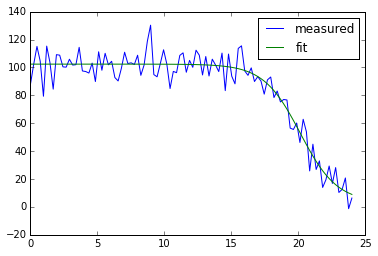

In [5]:

N = 100 #the number of time points
t_max = 24 #max time of experiment

t=np.linspace(0,t_max,N)

#some values to create fake data
a_create_fake_data = [90, #amplitude
    20, #t_50
    1, #width
    10] #offset

y_measured =my_func(t,a_create_fake_data) + np.random.normal(0,10,N)

#give the fitter an initial guess
a_guess = [90, #amplitude
    10, #t_50
    2, #width
    1] #offset


out = leastsq(my_residual,a_guess,args=(t,y_measured))

y_fit = my_func(t,out[0])
print out

plt.plot(t,y_measured, label='measured')
plt.plot(t,y_fit, label='fit')
plt.legend()
plt.show()

In [6]:


t = np.asarray(data['dim3'])
data['fit_result'] = np.zeros((len(data['dim1']),len(data['dim2']),4))
data['fit_residual'] = np.zeros((len(data['dim1']),len(data['dim2'])))
data['y_fit'] = np.zeros(data['M'].shape)
for iii in range(len(data['dim1'])):
    for i in range(20):
        y_measured = data['M'][iii,i,:].flatten()
        a_guess = np.asarray([1e5, #amplitude
            4, #t_50
            1, #width
            0]) #offset

        # out, fx, its, imode, smode = fmin_slsqp(my_residual,a_guess,args=(t,y_measured),bounds=[(0,1e9),(0.0001,None),(0.0001,26),(0,1e9)], full_output=True)
        out = leastsq(my_residual,a_guess,args=(t,y_measured))
        y_fit = my_func(t,out[0])
        data['y_fit'][iii,i,:] = y_fit
        data['fit_result'][iii,i,:] = out[0]
        data['fit_residual'][iii,i] = out[1]
    #     print out
        plt.subplot(4,5,i)
        plt.plot(t,y_measured,'.', label='measured')
        plt.plot(t,y_fit, label='fit')
        plt.title(data['dim2'][i].replace(' Results Final Conc.',''))
    #     plt.legend()
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    plt.tight_layout()
    fig.savefig('%s.png'%data['dim1'][iii], dpi=100)
    fig.clear()
# plt.show()

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_subplots.py:69: MatplotlibDeprecationWarning: The use of 0 (which ends up being the _last_ sub-plot) is deprecated in 1.4 and will raise an error in 1.5
  mplDeprecation)
/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:28: RuntimeWarning: overflow encountered in exp


In [24]:
with open("onur_data_including_fit.pkl",'w') as f:
    pickle.dump(data,f)